# Can Transformers learn ~~Transformers~~ to matrix multiply?

> Original idea: Andrej Karpathy on sequence sorting
>
> https://github.com/karpathy/minGPT/blob/master/demo.ipynb

Transformers are great to learn context dependencies.

Can they learn to matrix multiply, without even knowing numbers?



### Digits are embeddings:
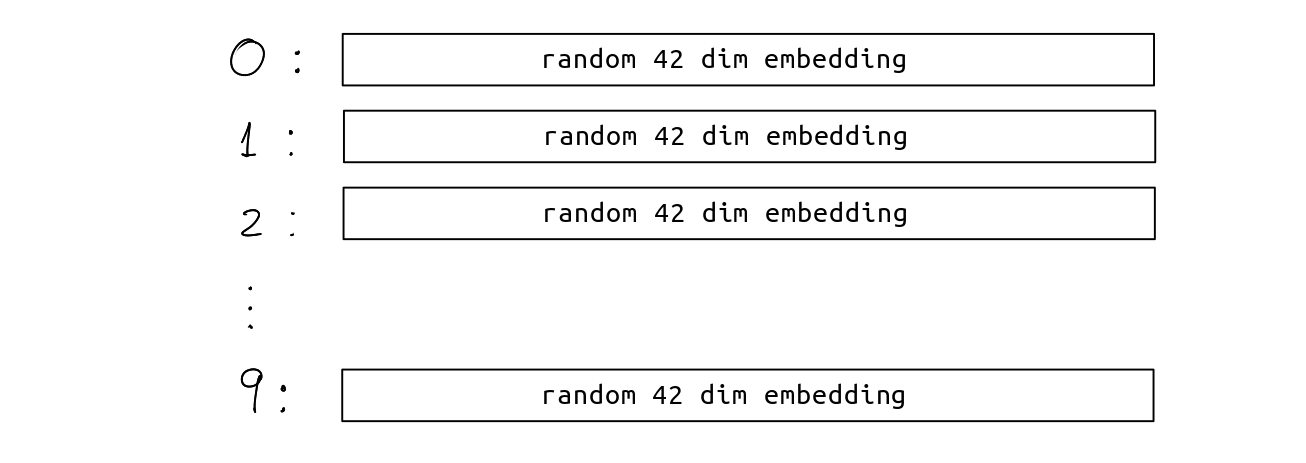


### Recall: Matrix multiplication
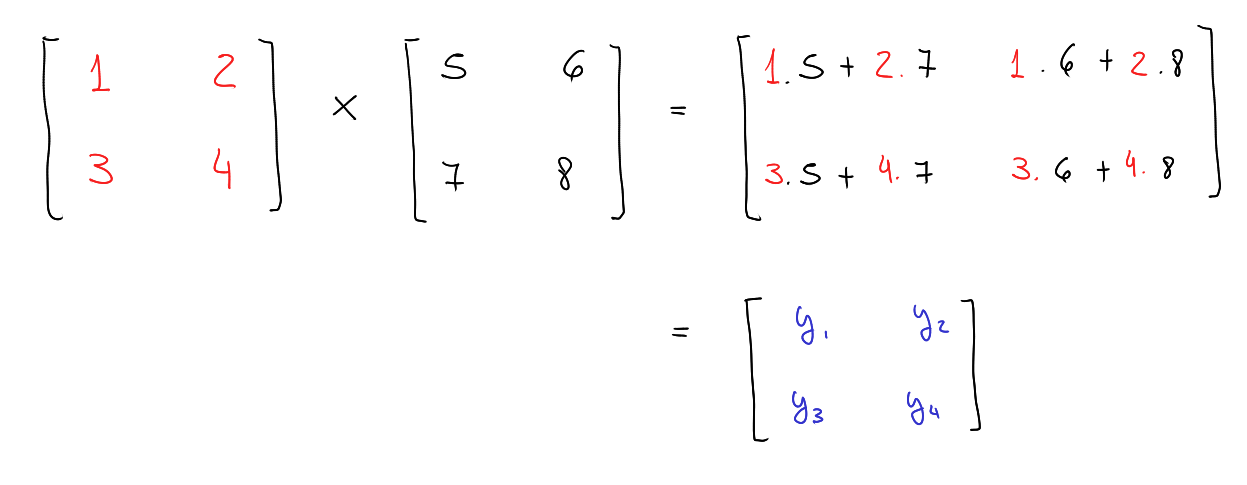
<h3><center>2x2 matrix multiplication</center></h3>

### Matrices are flattened as:
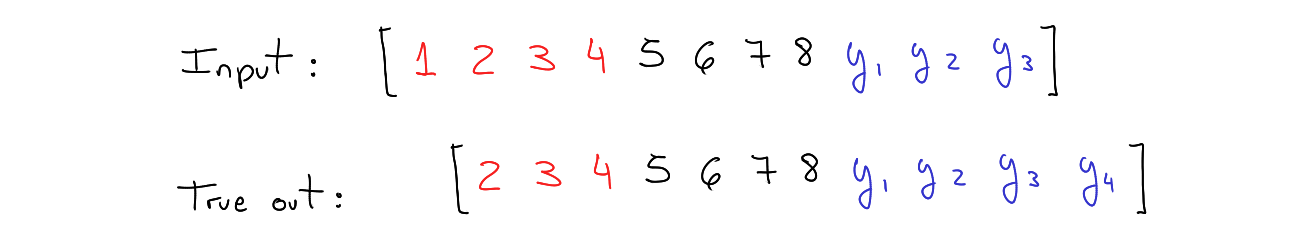

### What about 2 or more digits numbers?

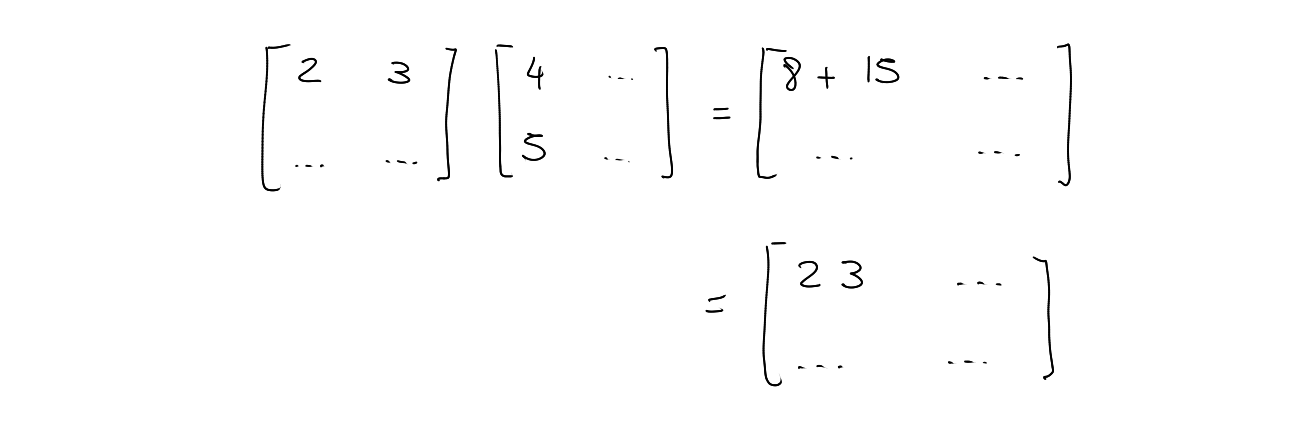

### Digits can be seen as words in a sentence, or character level tokenization

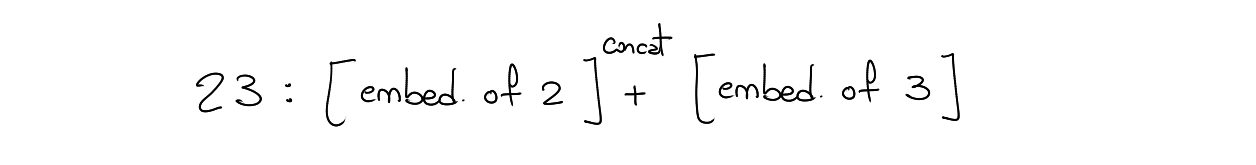

### Can 3 digit number appear in 2x2 base 10 matrices?

> Yes: `9*9 + 9*9 = 162`

### Easy solution: Matrices contain numbers from 0 to 7

> Max number: `7*7 + 7*7 = 98` wich can be represented with only two digits

### New input: All numbers are considered two-digit numbers:

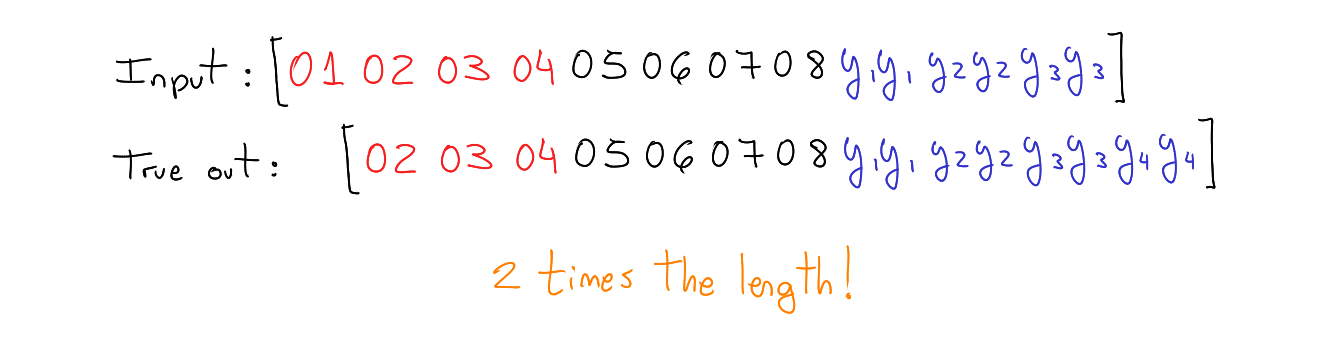

### Input dim:

> `(2 * 2) * 2 digits * 3 matrices - 1 hidden = 23`
>
> #### Loss computed over last 8 y_i values

## Code

In [2]:
!git clone https://github.com/karpathy/minGPT.git
%cd minGPT
!ls

fatal: destination path 'minGPT' already exists and is not an empty directory.
/home/jack/NLPbookstudygroup/Jack/Final Project/minGPT
demo.ipynb	LICENSE  minGPT      projects	setup.py
generate.ipynb	mingpt	 mingpt.jpg  README.md	tests


In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader


In [4]:
import numpy as np

In [5]:
from tqdm import tqdm

In [6]:
seed = 1337

In [7]:
from mingpt.utils import set_seed

set_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
t = torch.Tensor([5, 1, 30, 187]).to(torch.long)
t

tensor([  5,   1,  30, 187])

In [9]:
def int_to_digits(t, fill_digits):
    if len(t.shape) == 1:
        x = [[int(digit) for digit in str(num.item()).zfill(fill_digits)] for num in t]
        return torch.Tensor(x).to(torch.long).flatten()
    else:
        res = []
        with tqdm(total=len(t), desc="Converting numbers to individual digits") as pbar:
            for row in t:
                x = int_to_digits(row, fill_digits)
                res.append(x)
                pbar.update(1)
        return torch.stack(res).to(torch.long)
    
int_to_digits(t, 3)


tensor([0, 0, 5, 0, 0, 1, 0, 3, 0, 1, 8, 7])

In [10]:
# Example
int_to_digits(torch.Tensor([[1, 2],
                            [3, 4],
                            [5, 6]]).to(torch.long), 2)

Converting numbers to individual digits: 100%|██████████| 3/3 [00:00<00:00, 1825.46it/s]


tensor([[0, 1, 0, 2],
        [0, 3, 0, 4],
        [0, 5, 0, 6]])

In [11]:
import pickle

class MatrixDataset(Dataset):
    def __init__(self, split=[0.8, 0.2], num_examples=10_000, shape=[2,2], base=10, fill_digits=3, max_matrix_number=None):
        assert sum(split) == 1.0, "Split must sum to 1.0"

        self.split = split
        self.num_examples = num_examples

        self.base = base # Number of possible digits
        self.max_matrix_number = max_matrix_number if max_matrix_number else self.base - 1
        
        assert self.max_matrix_number < self.base, "self.max_matrix_number cannot be greater or equal than self.base"
        
        self.shape = shape
        self.length = self.mul(self.shape)
        self.fill_digits = fill_digits

        self.x = None
        self.y = None
        self.generate_examples()

    def mul(self, x):
        res = 1
        for elem in x:
            res *= elem
        return res

    def __len__(self):
        return len(self.x)

    def get_vocab_size(self):
        return self.base

    def get_block_size(self):
        # the length of the sequence that will feed into transformer,
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * self.fill_digits * 3 - 1

    def __getitem__(self, idx):
        assert idx in {'train', 'test'}, "key must be 'train' or 'test', not: {}".format(idx)

        # If idx is 'train' return first 0.8 * num_examples else return last 0.2 * num_examples
        n = int(self.num_examples * self.split[0])
        if idx == 'train':
            zipped_tensor = list(zip(self.x[:n], self.y[:n]))
        elif idx == 'test':
            zipped_tensor = list(zip(self.x[n:], self.y[n:]))

        return zipped_tensor
    
    def compute_solutions(self, X):
        # Compute matrix multiplication
        solutions = []
        with tqdm(total=len(X), desc="Computing matrix products") as pbar:
            for row in X:
                m1 = row[:self.length] # Flattened matrix 1
                m2 = row[self.length:] # Flattened matrix 2
                s = torch.matmul(m1.view(self.shape), m2.view(self.shape)).flatten()
                solutions.append(s)
                pbar.update(1)

        return torch.stack(solutions).to(torch.long)

    def generate_examples(self):
        init_examples = np.random.randint(low=0, high=self.max_matrix_number + 1, size=(self.num_examples, 2*self.length))
        train_set = set()
        for row in init_examples:
            # Add rows to set to remove duplicates
            train_set.add(tuple(row))
        
        num_set = len(train_set)
        count = 0
        with tqdm(total=self.num_examples, desc="Generating random matrices") as pbar:
            pbar.update(num_set)
            while num_set < self.num_examples:
                # Add new unique rows until num_examples is reached
                new_example = np.random.randint(low=0, high=self.max_matrix_number + 1, size=(2*self.length,))
                train_set.add(tuple(new_example))

                # Count repeated attempts
                if len(train_set) == num_set:
                    count += 1
                else:
                    count = 0
                    pbar.update(1)
                    
                num_set = len(train_set)
                if count > 1e6:
                    print("Warning: Repeated attempts to generate unique examples! Aborting example generation.")
                    break
                
        # Convert set of tuples to tensors
        X = torch.Tensor(list(train_set)).to(torch.long)

        # DO RANDOM SHUFFLE HERE
        X = X[torch.randperm(X.size()[0])]

        # Compute matrix multiplication

        solutions = self.compute_solutions(X)
        
        # Separate individual digits and pad with zeros
        X = int_to_digits(X, self.fill_digits)
        solutions = int_to_digits(solutions, self.fill_digits)


        # concatenate the problem specification and the solution
        cat = torch.cat((X, solutions), dim=1)

        # the inputs to the transformer will be the offset sequence
        x = cat[:, :-1].clone()
        y = cat[:, 1:].clone()

        # we only want to predict at output locations, mask out the loss at the input locations
        y[:, :self.fill_digits * 2 * self.length - 1] = -1

        self.x = x
        self.y = y


In [12]:
# print an example instance of the dataset
matrix_dataset = MatrixDataset(num_examples=1_000_000,
                               shape=[2,2],         # Matrix shape
                               fill_digits=3,       # Number of digits to represent each number
                               max_matrix_number=9) # Digits go from 0 to max_matrix_number

train_dataset = matrix_dataset['train']
test_dataset = matrix_dataset['test']

Converting numbers to individual digits: 100%|██████████| 1000000/1000000 [00:48<00:00, 20698.84it/s]


In [14]:
x, y = train_dataset[0]
x, y

(tensor([0, 0, 4, 0, 0, 2, 0, 0, 6, 0, 0, 1, 0, 0, 7, 0, 0, 9, 0, 0, 8, 0, 0, 2,
         0, 4, 4, 0, 4, 0, 0, 5, 0, 0, 5]),
 tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1,  0,  4,  4,  0,  4,  0,  0,  5,  0,  0,  5,  6]))

In [21]:
len(train_dataset), len(test_dataset)

(800000, 200000)

In [26]:
# Visualization functions
from math import sqrt

def combine_digits(lst, fill_digits):
    combined_lst = []
    for i in range(0, len(lst), fill_digits):
        combined_digits = lst[i:i+fill_digits]
        combined_num = int(''.join(map(str, combined_digits)))
        combined_lst.append(combined_num)
    return combined_lst


def list_to_matrix(x, fill_digits, is_double=False):
   
    
    if not is_double:
        # Square matrix of dim dxd
        n = len(x)
        d = int(sqrt(n//fill_digits))

        return torch.Tensor(combine_digits(x, fill_digits)).view([d,d]).numpy()
    else:
        m1 = x[:len(x)//2]
        m2 = x[len(x)//2:]
        
        n = len(m1)
        d = int(sqrt(n//fill_digits))
        
        t1 = torch.Tensor(combine_digits(m1, fill_digits)).view([d, d]).numpy()
        t2 = torch.Tensor(combine_digits(m2, fill_digits)).view([d, d]).numpy()
        
        return (t1, t2)

In [33]:
x[:piece*2]

tensor([0, 0, 4, 0, 0, 2, 0, 0, 6, 0, 0, 1, 0, 0, 7, 0, 0, 9, 0, 0, 8, 0, 0, 2])

In [50]:
print('As network input|output:')
for i, (a, b) in enumerate(zip(x,y)):
    print(f"{i}:", int(a), int(b))

print('\nAs matrices:')
piece = (len(x) + 1) // 3
print(list_to_matrix(x[:piece].tolist(), matrix_dataset.fill_digits))
print("x") # times
print(list_to_matrix(x[piece:2*piece].tolist(), matrix_dataset.fill_digits))
print("=")
print(list_to_matrix(y[-piece:].tolist(), matrix_dataset.fill_digits))

As network input|output:
0: 0 -1
1: 0 -1
2: 4 -1
3: 0 -1
4: 0 -1
5: 2 -1
6: 0 -1
7: 0 -1
8: 6 -1
9: 0 -1
10: 0 -1
11: 1 -1
12: 0 -1
13: 0 -1
14: 7 -1
15: 0 -1
16: 0 -1
17: 9 -1
18: 0 -1
19: 0 -1
20: 8 -1
21: 0 -1
22: 0 -1
23: 2 0
24: 0 4
25: 4 4
26: 4 0
27: 0 4
28: 4 0
29: 0 0
30: 0 5
31: 5 0
32: 0 0
33: 0 5
34: 5 6

As matrices:
[[4. 2.]
 [6. 1.]]
x
[[7. 9.]
 [8. 2.]]
=
[[44. 40.]
 [50. 56.]]


In [51]:
matrix_dataset.get_vocab_size(), matrix_dataset.get_block_size()

(10, 35)

In [52]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()

# Either model_type or (n_layer, n_head, n_embd) must be given
#model_config.model_type = 'gpt-nano'
model_config.model_type = None
model_config.n_layer = 2 # Default: 3
model_config.n_head = 2  # Default: 3
model_config.n_embd = 16 # Default: 48

model_config.vocab_size = matrix_dataset.get_vocab_size()
model_config.block_size = matrix_dataset.get_block_size()

model = GPT(model_config)

number of parameters: 0.01M


In [54]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # 5e-4 the model we're using is so small that we can go a bit faster
train_config.max_iters = 1_000
train_config.num_workers = 8
train_config.batch_size = 128
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [55]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 2.30541
iter_dt 16.08ms; iter 100: train loss 1.80048
iter_dt 19.61ms; iter 200: train loss 1.56064
iter_dt 16.68ms; iter 300: train loss 1.48971
iter_dt 15.92ms; iter 400: train loss 1.49576
iter_dt 20.39ms; iter 500: train loss 1.43422
iter_dt 17.54ms; iter 600: train loss 1.46056
iter_dt 16.15ms; iter 700: train loss 1.40165
iter_dt 16.30ms; iter 800: train loss 1.38770
iter_dt 16.00ms; iter 900: train loss 1.38341


KeyboardInterrupt: 

In [28]:
# now let's perform some evaluation
model.eval();

In [29]:
def eval_split(trainer, split, max_batches):
    fill_digits = matrix_dataset.fill_digits
    
    dataset = {'train':train_dataset,
               'test':test_dataset}[split]
    n = matrix_dataset.length # naugy direct access shrug
    n = n*fill_digits
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)
        
        # isolate the input pattern alone
        inp = x[:, :2*n]
        sol = y[:, -n:]
        # let the model sample the rest of the sequence
        cat = model.generate(inp, n, do_sample=False) # using greedy argmax, not sampling
        
        sol_candidate = cat[:, 2*n:] # isolate the filled in sequence
        # compare the predicted sequence to the true sequence
        correct = (sol == sol_candidate).all(1).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
                mistakes_printed_already += 1
                print("GPT claims that %s solved is \n%s but gt is \n%s\n" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
                
                t1, t2 = list_to_matrix(inp[i].tolist(), fill_digits, is_double=True)
                print("GPT claims that \n%s \nx \n%s\nsolved is \n%s \nbut gt is \n%s\n" % (t1,t2,
                                                                              list_to_matrix(sol_candidate[i].tolist(), fill_digits),
                                                                              list_to_matrix(sol[i].tolist(), fill_digits)))
        if max_batches is not None and b+1 >= max_batches:
            break
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_split(trainer, 'train', max_batches=50)
    test_score  = eval_split(trainer, 'test',  max_batches=50)

GPT claims that [0, 0, 4, 0, 0, 2, 0, 0, 6, 0, 0, 1, 0, 0, 7, 0, 0, 9, 0, 0, 8, 0, 0, 2] solved is 
[0, 4, 0, 0, 3, 6, 0, 5, 0, 0, 2, 4] but gt is 
[0, 4, 4, 0, 4, 0, 0, 5, 0, 0, 5, 6]

GPT claims that 
[[4. 2.]
 [6. 1.]] 
x 
[[7. 9.]
 [8. 2.]]
solved is 
[[40. 36.]
 [50. 24.]] 
but gt is 
[[44. 40.]
 [50. 56.]]

GPT claims that [0, 0, 6, 0, 0, 7, 0, 0, 8, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 0, 4, 0, 0, 2] solved is 
[0, 3, 4, 0, 4, 4, 0, 3, 6, 0, 4, 0] but gt is 
[0, 3, 4, 0, 4, 4, 0, 0, 8, 0, 4, 0]

GPT claims that 
[[6. 7.]
 [8. 0.]] 
x 
[[1. 5.]
 [4. 2.]]
solved is 
[[34. 44.]
 [36. 40.]] 
but gt is 
[[34. 44.]
 [ 8. 40.]]

GPT claims that [0, 0, 8, 0, 0, 5, 0, 0, 6, 0, 0, 6, 0, 0, 1, 0, 0, 4, 0, 0, 6, 0, 0, 7] solved is 
[0, 4, 6, 0, 7, 7, 0, 3, 6, 0, 6, 6] but gt is 
[0, 3, 8, 0, 6, 7, 0, 4, 2, 0, 6, 6]

GPT claims that 
[[8. 5.]
 [6. 6.]] 
x 
[[1. 4.]
 [6. 7.]]
solved is 
[[46. 77.]
 [36. 66.]] 
but gt is 
[[38. 67.]
 [42. 66.]]

train final score: 119/5000 = 2.38% correct
GPT claims 

In [30]:
original_list = [2, 6, 3, 2, 1, 4, 0, 8]+[2, 6, 3, 2, 1, 4, 0, 8]
fill_digits = 2

result = list_to_matrix(original_list, fill_digits=fill_digits, is_double=True)
print(result)

(array([[26., 32.],
       [14.,  8.]], dtype=float32), array([[26., 32.],
       [14.,  8.]], dtype=float32))


In [31]:
# let's run a random given sequence through the model as well
n = train_dataset.length # naugy direct access shrug
inp = torch.tensor([[0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0, 7, 0, 8]], dtype=torch.long).to(trainer.device)
assert inp[0].nelement() == n
with torch.no_grad():
    cat = model.generate(inp, n, do_sample=False)
sol = torch.sort(inp[0])[0]
sol_candidate = cat[:, n:]
print('input sequence  :', inp.tolist())
print('predicted sorted:', sol_candidate.tolist())
print('gt sort         :', sol.tolist())
print('matches         :', bool((sol == sol_candidate).all()))

AttributeError: 'list' object has no attribute 'length'